looking at change in entries at a particular timestamp across 8/31 --> 9/1/2021 by station

In [2]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md


In [3]:
engine= create_engine('sqlite:///mta_data.db')
engine.table_names()

['mta_data']

In [28]:
df_20210901=pd.read_sql('SELECT * FROM mta_data where DATE in ("08/31/2021","09/01/2021","09/02/2021");',engine)

In [29]:
#clean data
df_20210901.columns = [column.strip() for column in df_20210901.columns]
df_20210901["DATE_TIME"] = pd.to_datetime(df_20210901.DATE + " " + df_20210901.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [30]:
#check for any duplicate rows
(df_20210901
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
89003,S101,R070,00-00-02,ST. GEORGE,2021-09-01 16:00:00,2
89008,S101,R070,00-00-02,ST. GEORGE,2021-09-02 12:00:00,2
89004,S101,R070,00-00-02,ST. GEORGE,2021-09-01 20:00:00,2
89005,S101,R070,00-00-02,ST. GEORGE,2021-09-02 00:00:00,2
89001,S101,R070,00-00-02,ST. GEORGE,2021-09-01 08:00:00,2


In [8]:
#remove duplicate rows
df_20210901.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=True)
df_20210901.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)    


In [9]:
#check to see if the duplicate has been removed
mask = ((df_20210901["C/A"] == "S101") & 
(df_20210901["UNIT"] == "R070") & 
(df_20210901["SCP"] == "00-00-02") & 
(df_20210901["STATION"] == "ST. GEORGE")&
(df_20210901["DATE_TIME"]=="2021-09-01 20:00:00")	)

df_20210901[mask].head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
3570536,S101,R070,00-00-02,ST. GEORGE,1,SRT,09/01/2021,20:00:00,REGULAR,1396413,324,2021-09-01 20:00:00


In [10]:
#what is the total entries/exits for a timestamp at a turnstile
df_20210901[["PREV_DATE_TIME", "PREV_ENTRIES","PREV_EXITS"]] = (df_20210901
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE_TIME", "ENTRIES","EXITS"]
                                                       .apply(lambda grp: grp.shift(1)))
df_20210901.head()


/var/folders/s5/kqm0k4xj165fxvtjxq0njrq00000gn/T/ipykernel_1043/2724438207.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_20210901[["PREV_DATE_TIME", "PREV_ENTRIES","PREV_EXITS"]] = (df_20210901


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,PREV_DATE_TIME,PREV_ENTRIES,PREV_EXITS
3362402,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/31/2021,00:00:00,REGULAR,7627394,2609642,2021-08-31 00:00:00,NaT,NaN,NaN
3362403,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/31/2021,04:00:00,REGULAR,7627406,2609644,2021-08-31 04:00:00,2021-08-31 00:00:00,7627394.0,2609642.0
3362404,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/31/2021,08:00:00,REGULAR,7627421,2609698,2021-08-31 08:00:00,2021-08-31 04:00:00,7627406.0,2609644.0
3362405,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/31/2021,12:00:00,REGULAR,7627494,2609810,2021-08-31 12:00:00,2021-08-31 08:00:00,7627421.0,2609698.0
3362406,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/31/2021,16:00:00,REGULAR,7627664,2609847,2021-08-31 16:00:00,2021-08-31 12:00:00,7627494.0,2609810.0


In [11]:
# Drop the rows for the earliest date_time stamp in the df
df_20210901.dropna(subset=["PREV_DATE_TIME"], axis=0, inplace=True)
df_20210901.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,PREV_DATE_TIME,PREV_ENTRIES,PREV_EXITS
3362403,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/31/2021,04:00:00,REGULAR,7627406,2609644,2021-08-31 04:00:00,2021-08-31 00:00:00,7627394.0,2609642.0
3362404,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/31/2021,08:00:00,REGULAR,7627421,2609698,2021-08-31 08:00:00,2021-08-31 04:00:00,7627406.0,2609644.0
3362405,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/31/2021,12:00:00,REGULAR,7627494,2609810,2021-08-31 12:00:00,2021-08-31 08:00:00,7627421.0,2609698.0
3362406,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/31/2021,16:00:00,REGULAR,7627664,2609847,2021-08-31 16:00:00,2021-08-31 12:00:00,7627494.0,2609810.0
3362407,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/31/2021,20:00:00,REGULAR,7627947,2609878,2021-08-31 20:00:00,2021-08-31 16:00:00,7627664.0,2609847.0


In [12]:
def get_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
df_20210901["TIMEBLOCK_ENTRIES"] = df_20210901.apply(get_counts, axis=1, max_counter=10000)

15848006 2216515.0
2216520 15848006.0
10487784 2024.0
2024 10487784.0
265384 54590.0
54602 265384.0
19 55180.0
21 120061.0
11123659 4624026.0
1891101745 1104755.0
37 7682472.0


In [13]:
#calculate counts for exits

def get_counts(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["EXITS"], row["PREV_EXITS"])
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
df_20210901["TIMEBLOCK_EXITS"] = df_20210901.apply(get_counts, axis=1, max_counter=10000)

97079 19988.0
19990 97079.0
25 52200.0
24 287731.0
14324221 1392264.0
1428704905 145278.0
14 5192460.0


In [14]:
#check the calculation 
mask = ((df_20210901["C/A"] == "A011") & 
(df_20210901["UNIT"] == "R080") & 
(df_20210901["SCP"] == "01-03-00") & 
(df_20210901["STATION"] == "57 ST-7 AV") &
(df_20210901["DATE_TIME"].dt.date == datetime.datetime(2021, 9, 1).date()))

df_20210901[mask].head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,PREV_DATE_TIME,PREV_ENTRIES,PREV_EXITS,TIMEBLOCK_ENTRIES,TIMEBLOCK_EXITS
3364046,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,09/01/2021,00:00:00,REGULAR,885577414,489492608,2021-09-01 00:00:00,2021-08-31 20:00:00,885577465.0,489492692.0,51.0,84.0
3364047,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,09/01/2021,04:00:00,REGULAR,885577397,489492593,2021-09-01 04:00:00,2021-09-01 00:00:00,885577414.0,489492608.0,17.0,15.0
3364048,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,09/01/2021,08:00:00,REGULAR,885577389,489492411,2021-09-01 08:00:00,2021-09-01 04:00:00,885577397.0,489492593.0,8.0,182.0
3364049,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,09/01/2021,12:00:00,REGULAR,885577374,489492015,2021-09-01 12:00:00,2021-09-01 08:00:00,885577389.0,489492411.0,15.0,396.0
3364050,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,09/01/2021,16:00:00,REGULAR,885577321,489491801,2021-09-01 16:00:00,2021-09-01 12:00:00,885577374.0,489492015.0,53.0,214.0


In [15]:
#group turnstiles by station & calculate the total
station_df = df_20210901.groupby(["STATION", "DATE","TIME","DATE_TIME"]).agg({'TIMEBLOCK_ENTRIES':'sum','TIMEBLOCK_EXITS':'sum'}).reset_index()
station_df["TIMEBLOCK_TOTALS"]= station_df['TIMEBLOCK_ENTRIES']+station_df['TIMEBLOCK_EXITS']
station_df.head()

,STATION,DATE,TIME,DATE_TIME,TIMEBLOCK_ENTRIES,TIMEBLOCK_EXITS,TIMEBLOCK_TOTALS
0,1 AV,08/31/2021,04:00:00,2021-08-31 04:00:00,136.0,259.0,395.0
1,1 AV,08/31/2021,08:00:00,2021-08-31 08:00:00,503.0,1752.0,2255.0
2,1 AV,08/31/2021,12:00:00,2021-08-31 12:00:00,1557.0,3196.0,4753.0
3,1 AV,08/31/2021,16:00:00,2021-08-31 16:00:00,1785.0,2828.0,4613.0
4,1 AV,08/31/2021,20:00:00,2021-08-31 20:00:00,2798.0,4070.0,6868.0


In [16]:
hrly_df = pd.read_csv('hourly_prcp_2021', parse_dates=["time"])
hrly_df =  hrly_df[['time','prcp']]

In [17]:
#rolling sum over 4 h windows to smooth out varying timestamps
roll_data = station_df[["DATE_TIME","STATION","TIMEBLOCK_ENTRIES","TIMEBLOCK_EXITS","TIMEBLOCK_TOTALS"]].set_index('DATE_TIME').sort_index()
roll4h= roll_data.groupby("STATION").rolling('4H').sum().reset_index()

In [18]:
#use 145 ST bins as the base, as it is regular 4 h intervals
bin_4h = pd.DataFrame(station_df[station_df["STATION"]=="145 ST"]["DATE_TIME"]).reset_index(drop = True)
bin_4h

,DATE_TIME
0,2021-08-31 04:00:00
1,2021-08-31 08:00:00
2,2021-08-31 12:00:00
3,2021-08-31 16:00:00
4,2021-08-31 20:00:00
5,2021-09-01 00:00:00
6,2021-09-01 04:00:00
7,2021-09-01 08:00:00
8,2021-09-01 12:00:00
9,2021-09-01 16:00:00


In [19]:
#resample data into 4h bins & add DATE_TIME prev column
resample_df=station_df.groupby("STATION").resample('4H',on="DATE_TIME").sum().reset_index()
resample_df["TIME"]=resample_df['DATE_TIME'].dt.time
resample_df["DATE_TIME_prev"]= resample_df['DATE_TIME'] - pd.to_timedelta(1,'d')

#check
resample_df[resample_df["STATION"] == "PATH NEW WTC"]

,STATION,DATE_TIME,TIMEBLOCK_ENTRIES,TIMEBLOCK_EXITS,TIMEBLOCK_TOTALS,TIME,DATE_TIME_prev
5355,PATH NEW WTC,2021-08-31 04:00:00,332.0,1378.0,1710.0,04:00:00,2021-08-30 04:00:00
5356,PATH NEW WTC,2021-08-31 08:00:00,1968.0,9188.0,11156.0,08:00:00,2021-08-30 08:00:00
5357,PATH NEW WTC,2021-08-31 12:00:00,1844.0,4306.0,6150.0,12:00:00,2021-08-30 12:00:00
5358,PATH NEW WTC,2021-08-31 16:00:00,8773.0,3221.0,11994.0,16:00:00,2021-08-30 16:00:00
5359,PATH NEW WTC,2021-08-31 20:00:00,7599.0,2320.0,9919.0,20:00:00,2021-08-30 20:00:00
5360,PATH NEW WTC,2021-09-01 00:00:00,1497.0,548.0,2045.0,00:00:00,2021-08-31 00:00:00
5361,PATH NEW WTC,2021-09-01 04:00:00,421.0,1130.0,1551.0,04:00:00,2021-08-31 04:00:00
5362,PATH NEW WTC,2021-09-01 08:00:00,1743.0,7544.0,9287.0,08:00:00,2021-08-31 08:00:00
5363,PATH NEW WTC,2021-09-01 12:00:00,1920.0,4052.0,5972.0,12:00:00,2021-08-31 12:00:00
5364,PATH NEW WTC,2021-09-01 16:00:00,7973.0,2527.0,10500.0,16:00:00,2021-08-31 16:00:00


In [20]:
#check calc bin calc
station_df[
        (station_df["DATE_TIME"] < "2021-08-31 08:00:00")&
        (station_df["STATION"] == "PATH NEW WTC")
        ].sum()

/var/folders/s5/kqm0k4xj165fxvtjxq0njrq00000gn/T/ipykernel_1043/2104147492.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  station_df[


STATION              PATH NEW WTCPATH NEW WTCPATH NEW WTCPATH NEW W...
DATE                 08/31/202108/31/202108/31/202108/31/202108/31/...
TIME                 04:19:4804:37:4704:55:5604:55:5905:01:3405:05:...
TIMEBLOCK_ENTRIES                                                332.0
TIMEBLOCK_EXITS                                                 1378.0
TIMEBLOCK_TOTALS                                                1710.0
dtype: object

In [21]:
#merge 8.31 and 9.1 dataframes on time to calculate %change
merged_resample = pd.merge(resample_df, 
                        resample_df, 
                        how= 'inner',
                        left_on= ('STATION','DATE_TIME') , 
                        right_on = ('STATION','DATE_TIME_prev')
                        )

merged_resample ['p_delta']= merged_resample["TIMEBLOCK_TOTALS_y"]/  merged_resample["TIMEBLOCK_TOTALS_x"] -1
merged_resample ['delta']= merged_resample["TIMEBLOCK_TOTALS_y"]-merged_resample["TIMEBLOCK_TOTALS_x"]


In [22]:
(merged_resample[merged_resample["DATE_TIME_y"] =="2021-09-02 00:00:00"]
.sort_values("delta",ascending=True).head(20) )


,STATION,DATE_TIME_x,TIMEBLOCK_ENTRIES_x,TIMEBLOCK_EXITS_x,TIMEBLOCK_TOTALS_x,TIME_x,DATE_TIME_prev_x,DATE_TIME_y,TIMEBLOCK_ENTRIES_y,TIMEBLOCK_EXITS_y,TIMEBLOCK_TOTALS_y,TIME_y,DATE_TIME_prev_y,p_delta,delta
1215,86 ST,2021-09-01,2767.0,4062.0,6829.0,00:00:00,2021-08-31,2021-09-02,1340.0,2149.0,3489.0,00:00:00,2021-09-01,-0.489091,-3340.0
3074,METS-WILLETS PT,2021-09-01,6285.0,606.0,6891.0,00:00:00,2021-08-31,2021-09-02,2290.0,1592.0,3882.0,00:00:00,2021-09-01,-0.436657,-3009.0
2392,FLUSHING-MAIN,2021-09-01,2261.0,5205.0,7466.0,00:00:00,2021-08-31,2021-09-02,1443.0,3219.0,4662.0,00:00:00,2021-09-01,-0.375569,-2804.0
3888,TIMES SQ-42 ST,2021-09-01,4431.0,3806.0,8237.0,00:00:00,2021-08-31,2021-09-02,2333.0,3236.0,5569.0,00:00:00,2021-09-01,-0.323904,-2668.0
104,125 ST,2021-09-01,2569.0,4139.0,6708.0,00:00:00,2021-08-31,2021-09-02,1199.0,3065.0,4264.0,00:00:00,2021-09-01,-0.364341,-2444.0
1270,96 ST,2021-09-01,1671.0,2569.0,4240.0,00:00:00,2021-08-31,2021-09-02,740.0,1137.0,1877.0,00:00:00,2021-09-01,-0.557311,-2363.0
676,34 ST-PENN STA,2021-09-01,4228.0,4717.0,8945.0,00:00:00,2021-08-31,2021-09-02,2774.0,3863.0,6637.0,00:00:00,2021-09-01,-0.258021,-2308.0
511,23 ST,2021-09-01,3919.0,2416.0,6335.0,00:00:00,2021-08-31,2021-09-02,2430.0,1754.0,4184.0,00:00:00,2021-09-01,-0.339542,-2151.0
654,34 ST-HERALD SQ,2021-09-01,4781.0,3759.0,8540.0,00:00:00,2021-08-31,2021-09-02,3592.0,2853.0,6445.0,00:00:00,2021-09-01,-0.245316,-2095.0
1072,72 ST,2021-09-01,1424.0,1914.0,3338.0,00:00:00,2021-08-31,2021-09-02,698.0,874.0,1572.0,00:00:00,2021-09-01,-0.529059,-1766.0


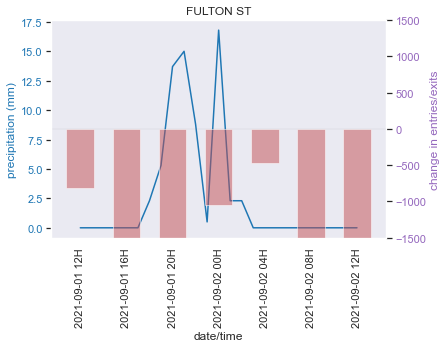

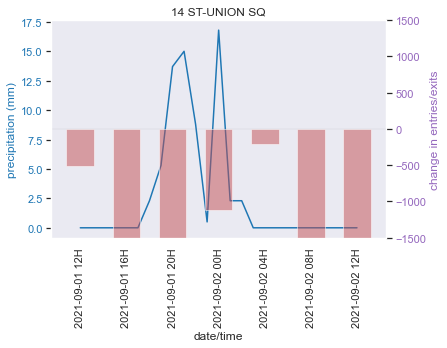

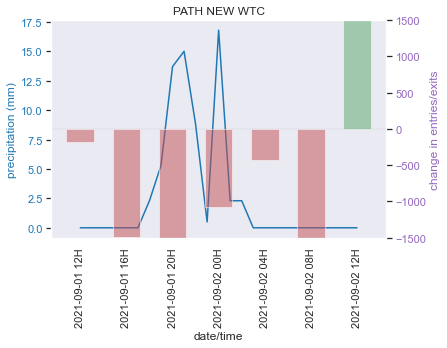

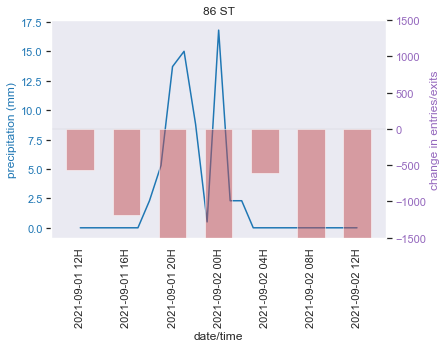

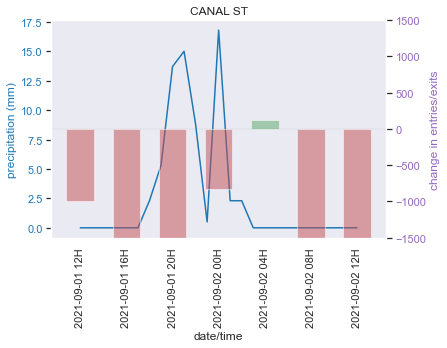

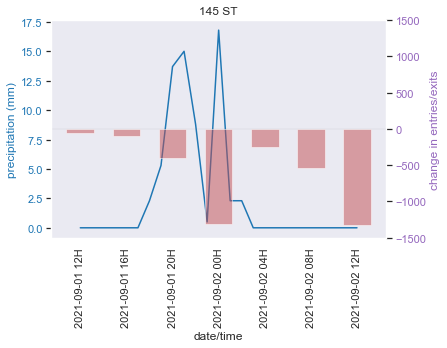

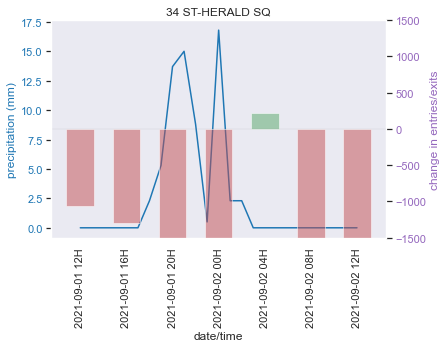

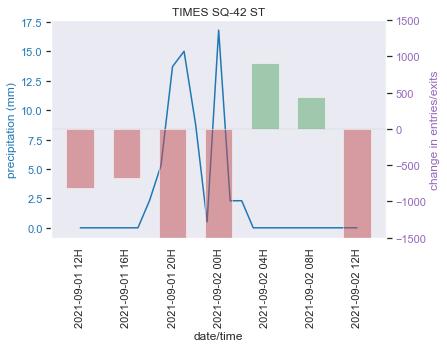

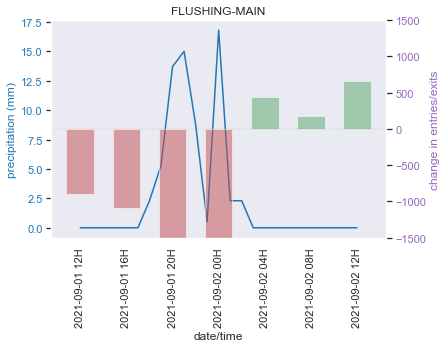

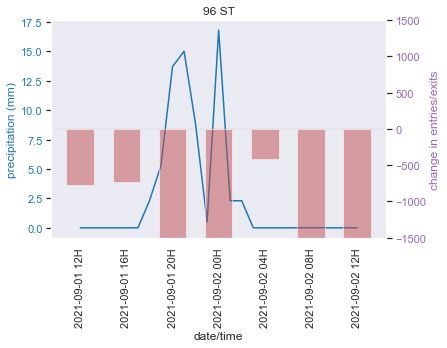

In [32]:
#graphs for decreasing stations

list = ["FULTON ST","14 ST-UNION SQ","PATH NEW WTC","86 ST","CANAL ST","145 ST",
"34 ST-HERALD SQ","TIMES SQ-42 ST","FLUSHING-MAIN","96 ST"]

for i in list:

    prcp_plot = hrly_df.loc[
                (hrly_df["time"]>="2021-09-01 12:00:00") &
                (hrly_df["time"]<="2021-09-02 12:00:00" ) ]

    station_plot=merged_resample.loc[
                (merged_resample["STATION"]==i)& 
                (merged_resample["DATE_TIME_y"]>="2021-09-01 12:00:00") &
                (merged_resample["DATE_TIME_y"]<="2021-09-02 12:00:00" )]
    station_plot
    
    sns.set_theme()
    sns.set_style("dark")

    x= prcp_plot.time
    y= prcp_plot.prcp
    
    fig, ax1 = plt.subplots()
    
    color = 'tab:blue'
    ax1.set_xlabel('date/time')
    ax1.set_ylabel('precipitation (mm)', color=color)
    ax1.plot(x, y, color=color)
    ax1.tick_params(axis ='y' , length = 5, direction = 'out')
    plt.xticks(rotation = 90)
    
    hours = md.HourLocator(interval = 4)
    plt.gca().xaxis.set_major_locator(hours)
    plt.gca().xaxis.set_major_formatter(md.DateFormatter("%Y-%m-%d %H" +"H"))
    ax1.tick_params(axis='y', labelcolor=color)
    
    x= station_plot.DATE_TIME_y
    z= station_plot.delta

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:purple'
    ax2.set_ylabel('change in entries/exits', color=color)  # we already handled the x-label with ax1
    ax2.bar(x, z,
            color=(station_plot['delta']>0).map({True:'g', False:'r'}),
        width=0.1,
        alpha=0.5)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([-1500,1500])

    plt.axhline(y = 0, linewidth= 0.1, color="gray")
    plt.title(i)
    plt.savefig('decreases_20210901_{}.png'.format(list.index(i)))

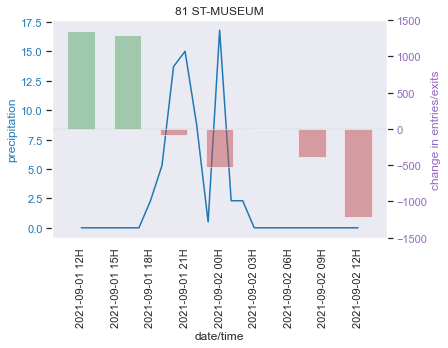

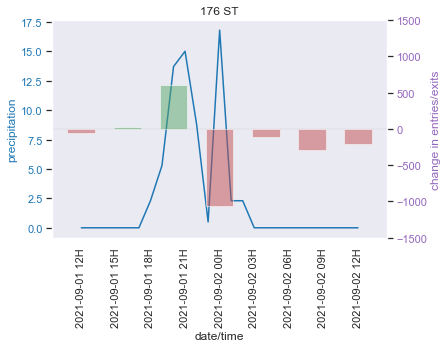

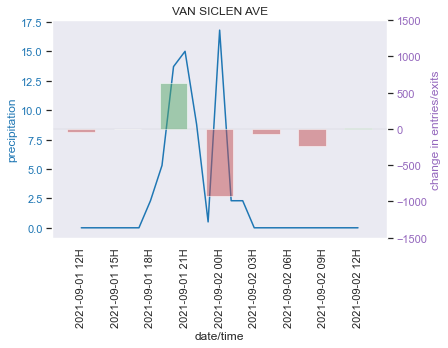

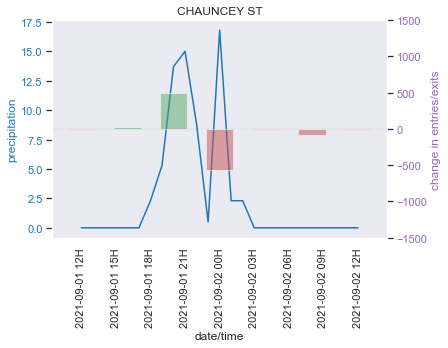

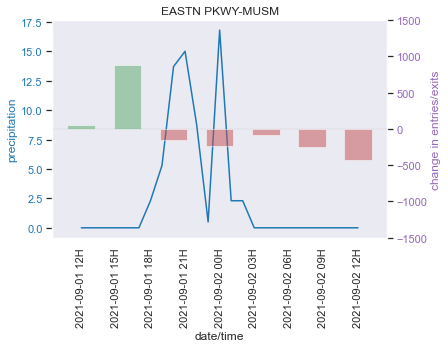

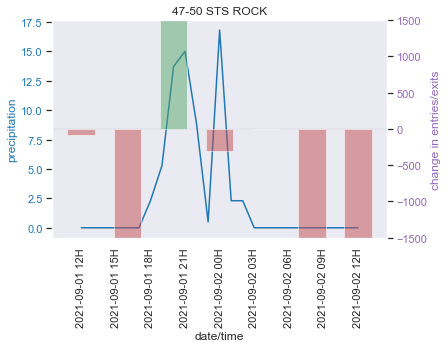

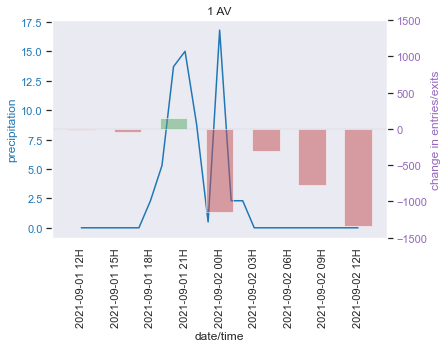

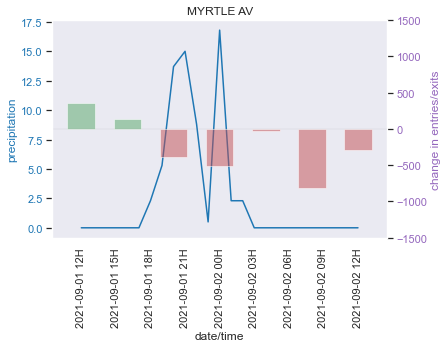

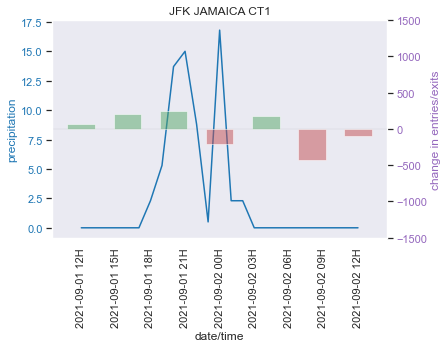

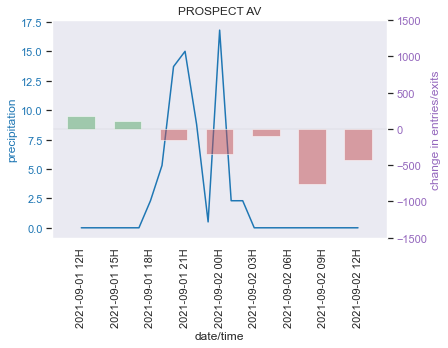

In [24]:
#graphs for increasing stations

list = ["81 ST-MUSEUM","176 ST","VAN SICLEN AVE","CHAUNCEY ST","EASTN PKWY-MUSM","47-50 STS ROCK",
"1 AV","MYRTLE AV","JFK JAMAICA CT1","PROSPECT AV"]

for i in list:

    prcp_plot = hrly_df.loc[(hrly_df["time"]>="2021-09-01 12:00:00") &
    (hrly_df["time"]<="2021-09-02 12:00:00" ) ]

    station_plot=merged_resample.loc[
    (merged_resample["STATION"]==i)& 
    (merged_resample["DATE_TIME_y"]>="2021-09-01 12:00:00") &(merged_resample["DATE_TIME_y"]<="2021-09-02 12:00:00" )]
    station_plot
    
    sns.set_theme()
    sns.set_style("dark")

    x= prcp_plot.time
    y= prcp_plot.prcp
    
    fig, ax1 = plt.subplots()
    
    color = 'tab:blue'
    ax1.set_xlabel('date/time')
    ax1.set_ylabel('precipitation', color=color)
    ax1.plot(x, y, color=color)
    plt.xticks(rotation = 90)
    plt.gca().xaxis.set_major_formatter(md.DateFormatter("%Y-%m-%d %H" +"H"))
    ax1.tick_params(axis='y', labelcolor=color)
    
    x= station_plot.DATE_TIME_y
    z= station_plot.delta

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:purple'
    ax2.set_ylabel('change in entries/exits', color=color)  # we already handled the x-label with ax1
    ax2.bar(x, z,
            color=(station_plot['delta']>0).map({True:'g', False:'r'}),
        width=0.1,
        alpha=0.5)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([-1500,1500])

    plt.axhline(y = 0, linewidth= 0.1, color="gray")
    plt.title(i)
    plt.savefig('increases_20210901_{}.png'.format(list.index(i)))
